In [279]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import ast
import warnings

# Configuration for plotting and warnings
sns.set(context='notebook', font_scale=1.1, style='ticks', rc={'figure.figsize': (8, 3), 'figure.facecolor': 'none', 'axes.facecolor': 'none'})
plt.set_loglevel('WARNING')
plt.rcParams.update({'lines.markeredgewidth': 1})
%config InlineBackend.figure_format = 'svg'
warnings.filterwarnings("ignore")

### Settings

In [280]:
BASE_FIGURE_PATH = "figures/"

ALPHA = 0.25

### Load benchmarking results

In [281]:
"""
WAYMAX
"""

df_waymax_speed_without_obs = pd.read_csv('waymax_speed_03_1720.csv')
df_waymax_speed_without_obs['Compute obs.'] = False

df_waymax_with_obs = pd.read_csv('waymax_speed_04_0944_wi_obs_a100.csv')
df_waymax_with_obs['Compute obs.'] = True

df_waymax_metadata = np.load('waymax_obj_dist.npy')

# Combine
df_waymax_speed = pd.concat([df_waymax_with_obs])
df_waymax_speed = df_waymax_speed.rename(columns={'device_name': 'Device', 'simulator': 'Simulator'}) 

"""
GPUDRIVE
"""

df_gdrive_speed_rtx = pd.read_csv('gpudrive_speed_04_1357.csv', index_col=False) # random-actors
df_gdrive_speed_rtx["simulator"] = "GPUDrive"
df_gdrive_speed_rtx['Compute obs.'] = True

df_gdrive_speed_a100 = pd.read_csv('gpudrive_speed_04_2026.csv', index_col=False) # random-actors
df_gdrive_speed_a100['Compute obs.'] = True

# Combine
df_gdrive_speed = pd.concat([df_gdrive_speed_rtx, df_gdrive_speed_a100])
df_gdrive_speed.reset_index(drop=True, inplace=True)
df_gdrive_speed = df_gdrive_speed.rename(columns={'device_name': 'Device', 'simulator': 'Simulator'}) 

df_gdrive_metadata = pd.read_csv('gpudrive_metadata_bs_1024.csv')

# Variance dataframes
df_gpudrive_1_scene = pd.read_csv('gpudrive_1_scene_04_1705.csv')
df_gpudrive_1_scene['Compute obs.'] = True

df_gpudrive_1_scene_metadata = pd.read_csv('gpudrive_1_scene_metadata_04_1705.csv')

df_gpudrive_100_scene = pd.read_csv('gpudrive_100_scene_04_1836.csv')
df_gpudrive_100_scene['Compute obs.'] = True

df_gpudrive_100_scene_metadata = pd.read_csv('gpudrive_100_scene_metadata_04_1836.csv')

### Part 1: **Controlled agent FPS**

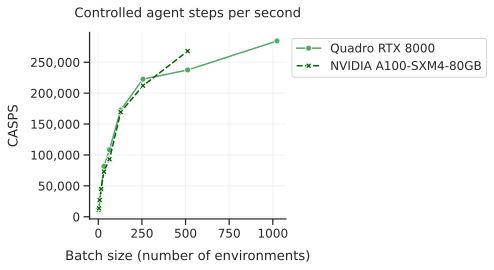

In [282]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

# Performance
sns.lineplot(data=df_gdrive_speed, x='batch_size (num envs)', y='cont_agent_fps', hue='Device', style='Device', marker='o', markers=True, ax=ax, palette=['g', 'darkgreen'])

ax.set_xlabel('Batch size (number of environments)', labelpad=10)
ax.set_ylabel('CASPS', labelpad=10)

ax.set_title('Controlled agent steps per second', y=1.05)
ax.grid(True, alpha=ALPHA)

ax.legend(fontsize=12, loc='best', bbox_to_anchor=(1, 1))
plt.tight_layout()
sns.despine()

ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.savefig(f'{BASE_FIGURE_PATH}/gpudrive_sim_perf_0604_cont_afps.pdf', bbox_inches = 'tight')

In [283]:
df_gdrive_speed[df_gdrive_speed['batch_size (num envs)'] == 1024].T

,9
Simulator,GPUDrive
Device,Quadro RTX 8000
device_mem,46080.0
actors,random
batch_size (num envs),1024
avg_time_per_reset (ms),46441.198215
avg_time_per_step (ms),28.931227
all_agent_fps (throughput),4530468.013724
val_agent_fps (goodput),2132228.933949
cont_agent_fps,284398.581062


### Part 2: **Agent FPS** | All objects for which we generate observations

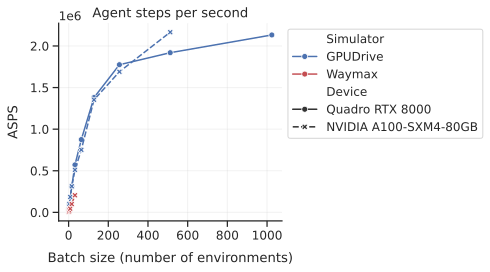

In [289]:
df_all = pd.concat([df_gdrive_speed, df_waymax_speed])

fig, ax = plt.subplots(1, 1, figsize=(7, 4))

# Performance
sns.lineplot(data=df_all, x='batch_size (num envs)', y='val_agent_fps (goodput)', style='Device', hue='Simulator', marker='o', markers=True, ax=ax, palette=['b', 'r'])
#ax.text(65, 170_000,'OOM', fontsize=12, color='r')

ax.set_xlabel('Batch size (number of environments)', labelpad=10)
ax.set_ylabel('ASPS', labelpad=10)

ax.set_title('Agent steps per second')
ax.grid(True, alpha=ALPHA)

ax.legend(fontsize=12, loc='best', bbox_to_anchor=(1, 1))
plt.tight_layout()
sns.despine()

plt.savefig(f'{BASE_FIGURE_PATH}/gpudrive_sim_perf_0604.pdf', bbox_inches = 'tight')

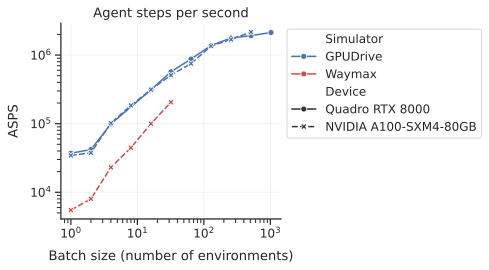

In [285]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

# Performance
sns.lineplot(data=df_all, x='batch_size (num envs)', y='val_agent_fps (goodput)', style='Device', hue='Simulator', marker='o', markers=True, ax=ax, palette=['b', 'r'])
#ax.text(65, 170_000,'OOM', fontsize=12, color='r')

ax.set_xlabel('Batch size (number of environments)', labelpad=10)
ax.set_ylabel('ASPS', labelpad=10)

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_title('Agent steps per second')
ax.grid(True, alpha=ALPHA)

ax.legend(fontsize=12, loc='best', bbox_to_anchor=(1, 1))
plt.tight_layout()
sns.despine()

plt.savefig(f'{BASE_FIGURE_PATH}/gpudrive_sim_perf_0604.pdf', bbox_inches = 'tight')

### Part 3. Affect of agent distribution on simulator performance

In [286]:
rand_dataset_afps = df_gdrive_speed_a100[df_gdrive_speed_a100['batch_size (num envs)'] == 512]['val_agent_fps (goodput)'].item()
rand_dataset_cafps = df_gdrive_speed_a100[df_gdrive_speed_a100['batch_size (num envs)'] == 512]['cont_agent_fps'].item()
rand_dataset_obj_dist = np.array(ast.literal_eval(df_gdrive_metadata[df_gdrive_metadata['num_envs (BS)'] == 1024]['num_valid_objects_per_scene (dist)'].values[0]))
rand_dataset_std = rand_dataset_obj_dist.std()

one_scene_afps = df_gpudrive_1_scene[df_gpudrive_1_scene['batch_size (num envs)'] == 512]['val_agent_fps (goodput)'].item()
one_scene_obj_dist = np.array(ast.literal_eval(df_gpudrive_1_scene_metadata[df_gpudrive_1_scene_metadata['num_envs (BS)'] == 512]['num_valid_objects_per_scene (dist)'].values[0]))
one_scene_std = one_scene_obj_dist.std()
one_scene_cafps = df_gpudrive_1_scene[df_gpudrive_1_scene['batch_size (num envs)'] == 512]['cont_agent_fps'].item()

# hundred_scene_afps = df_gpudrive_100_scene[df_gpudrive_100_scene['batch_size (num envs)'] == 512]['val_agent_fps (goodput)'].item()
# hundred_scene_obj_dist = np.array(ast.literal_eval(df_gpudrive_100_scene_metadata[df_gpudrive_100_scene_metadata['num_envs (BS)'] == 512]['num_valid_objects_per_scene (dist)'].values[0]))
# hundred_scene_std = hundred_scene_obj_dist.std()
# hundred_scene_cafps = df_gpudrive_100_scene[df_gpudrive_1_scene['batch_size (num envs)'] == 512]['cont_agent_fps'].item()

In [287]:
df_var_agents = pd.DataFrame({
  'Agent variation': ['Variable', 'Uniform'],
  'Agent distribution std.': [rand_dataset_std, one_scene_std],
  'AFPS': [rand_dataset_afps, one_scene_afps],
  'Controlled agent FPS': [rand_dataset_cafps, one_scene_cafps],
})

df_var_agents

,Agent variation,Agent distribution std.,AFPS,Controlled agent FPS
0,Variable,40.073564,2.165600e+06,268012.240811
1,Uniform,0.000000,4.936505e+06,280939.325399


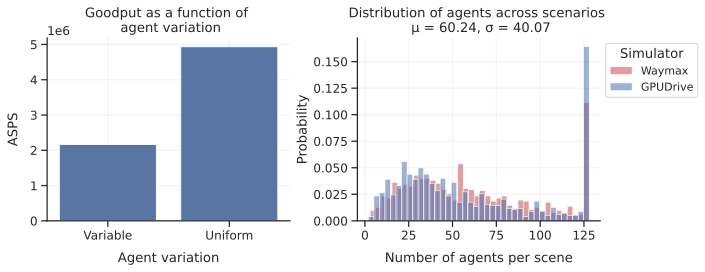

In [288]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

sns.barplot(data=df_var_agents, x='Agent variation', y='AFPS', ax=axs[0], color='b')

# AFPS as a function of scenes
axs[0].set_xlabel('Agent variation', labelpad=10)
axs[0].set_ylabel('ASPS', labelpad=10)

# Distribution of agents
sns.histplot(df_waymax_metadata, stat='probability', color='r', label='Waymax', bins=40, alpha=0.55, ax=axs[1], legend=True)
sns.histplot(rand_dataset_obj_dist, color='b', label='GPUDrive', stat='probability', bins=40, alpha=0.55, ax=axs[1]) 
axs[0].grid(True, alpha=ALPHA)
axs[1].grid(True, alpha=ALPHA)
axs[1].set_xlabel('Number of agents per scene', labelpad=10)    

axs[0].set_title(f'Goodput as a function of \n agent variation')
axs[1].set_title(f'Distribution of agents across scenarios \n μ = {rand_dataset_obj_dist.mean():.2f}, σ = {rand_dataset_std:.2f}')
axs[1].legend(title='Simulator', fontsize=11, loc='best', bbox_to_anchor=(1, 1))

plt.tight_layout()

sns.despine()

plt.savefig(f'{BASE_FIGURE_PATH}/gpudrive_sim_perf_agent_variation.pdf', bbox_inches = 'tight')

#### **END**

### Waymax conditions

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(11, 3.5))

fig.suptitle('Waymax runtime benchmark without computing observations.', fontsize=13, y=1.02)   

sns.lineplot(data=df_waymax_speed_without_obs, x='batch_size (num envs)', y='avg_time_per_step (ms)', marker='o', ax=axs[0], color='b', label='Measured Step')
axs[0].axhline(y=2.86, color='red', linestyle='--', label='Reported Step (BS=16, 2.86)',)
axs[0].set_title('Step')

sns.lineplot(data=df_waymax_speed_without_obs, x='batch_size (num envs)', y='avg_time_per_reset (ms)', marker='o', ax=axs[1], color='b', label='Measured Reset')
axs[1].axhline(y=0.81, color='red', linestyle='--', label='Reported Reset (BS=16, 0.81)',)
axs[1].set_title('Reset')

axs[0].set_ylabel('Wallclock time (ms)')
axs[1].set_ylabel('Wallclock time (ms)')
axs[2].set_ylabel(' ')

sns.lineplot(data=df_waymax_speed_without_obs, x='batch_size (num envs)', y='all_agent_fps (throughput)', marker='o', ax=axs[2], color='k', label='Throughput')
sns.lineplot(data=df_waymax_speed_without_obs, x='batch_size (num envs)', y='val_agent_fps (goodput)', marker='o', ax=axs[2], color='g', label='Goodput')

axs[2].set_title('Frames per second')
axs[0].grid(True, alpha=0.2)
axs[1].grid(True, alpha=0.2)
axs[2].grid(True, alpha=0.2)
axs[2].get_yaxis().set_major_formatter(
matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
axs[0].legend(fontsize=9, loc='best',) #bbox_to_anchor=(1, 1))
axs[1].legend(fontsize=9, loc='best',) #bbox_to_anchor=(1, 1))

plt.tight_layout()
sns.despine()   

In [ ]:
#df_waymax_speed[['batch_size (num envs)', 'avg_time_per_reset (ms)', 'avg_time_per_step (ms)', 'comp_obs']]

plt.title('Average time to step through the environment')
plt.ylabel('Time in ms')
sns.barplot(data=df_waymax_speed, x='batch_size (num envs)', y='avg_time_per_step (ms)', hue='Compute observations')
plt.grid(True, alpha=0.2)
sns.despine();

In [ ]:
df_waymax_metadata